# Paintball plot of updraft helicity tracks

## Setup

In [1]:
# Import statements

import xarray as xr
import matplotlib.pyplot as plt
from typing import List
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
from scipy import stats
from scipy.ndimage import label
import matplotlib.colors as mcolors 

# Set default style to dark background because I like it better
plt.style.use("dark_background")
plt.rcParams["hatch.linewidth"] = 0.3


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    elif init == 17:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-01 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})

def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


In [3]:
# Read in 20-23Z initializations
wofs_all = [get_wofs_all(n) for n in range(20,24,1)]

# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


/tmp/ipykernel_4184817/583318187.py:19: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_4184817/583318187.py:19: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_4184817/583318187.py:19: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_4184817/583318187.py:19: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")


In [4]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)

# Grab the 5 wettest and driest ensemble members
ranking = [r.ne.sortby(r).load() for r in rain12_aoi]
driest, wettest = [r[:5] for r in ranking], [r[-5:] for r in ranking]

# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]

# Select wet and dry members
wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]


## Plot

In [5]:
# Extract updraft helicity
uh_wet = get_field(
    wofs_wet, "uh_0to2", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init
).stack(run=("init", "ne"))
uh_dry = get_field(
    wofs_dry, "uh_0to2", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init
).stack(run=("init", "ne"))


In [8]:
# Get colors for paintball plot
colors = plt.get_cmap('hsv')(np.linspace(0,1,20))

Text(0.5, 0.98, '01-02 UTC 0-2km Updraft Heli. Swath Paintballs > 20m$^2$s$^{-2}$')

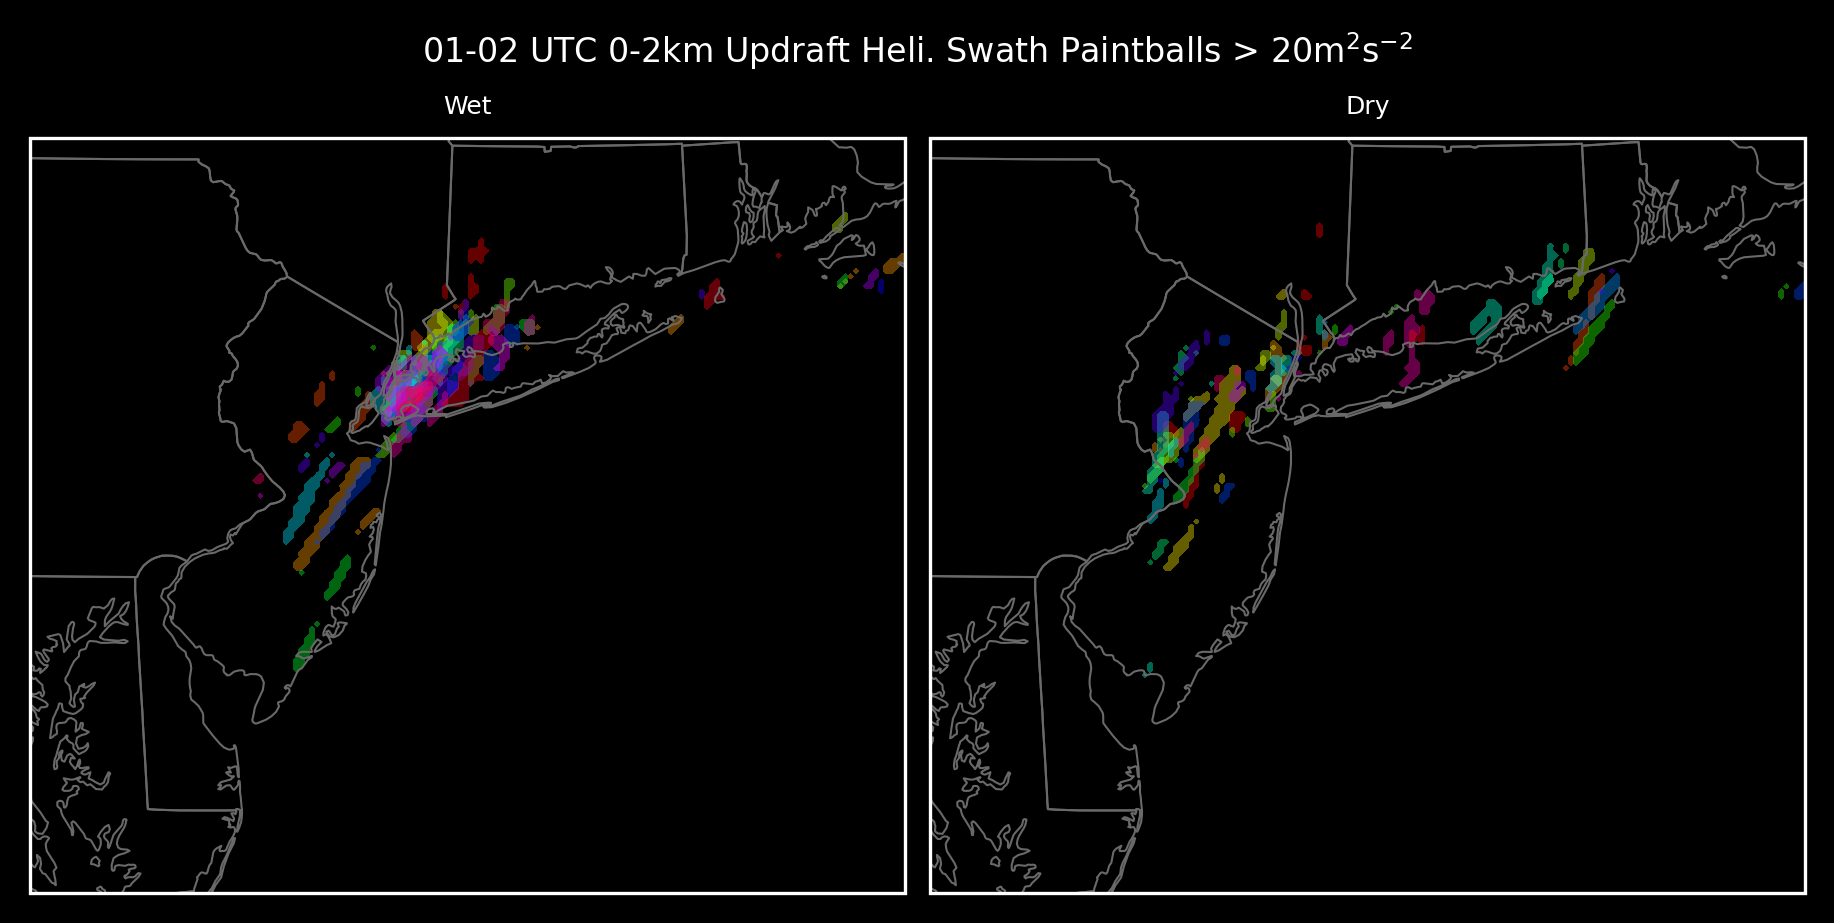

In [48]:
data = [uh_wet.max(dim="time"),uh_dry.max(dim="time")]
titles = ["Wet","Dry"]

# Make a figure with 2 by 1 subplots
fig, axes = plt.subplots(
    1,
    2,
    figsize=(6, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i,ax in enumerate(axes.flat):
    for j in range(len(data[i].run)):
        p = ax.contourf(lon,lat,data[i].isel(run=j)>20,
                        transform=ccrs.PlateCarree(),
                        levels=[0.5,1.5],
                        colors=[colors[j]],alpha=0.4
        )
    p.axes.add_feature(cfeature.STATES,linewidth=0.5,edgecolor="dimgray")
    ax.set_title(titles[i],fontsize=6)
    ax.set_extent([-76.5,-70.5,38,42])

plt.suptitle("01-02 UTC 0-2km Updraft Heli. Swath Paintballs > 20m$^2$s$^{-2}$",fontsize=8)

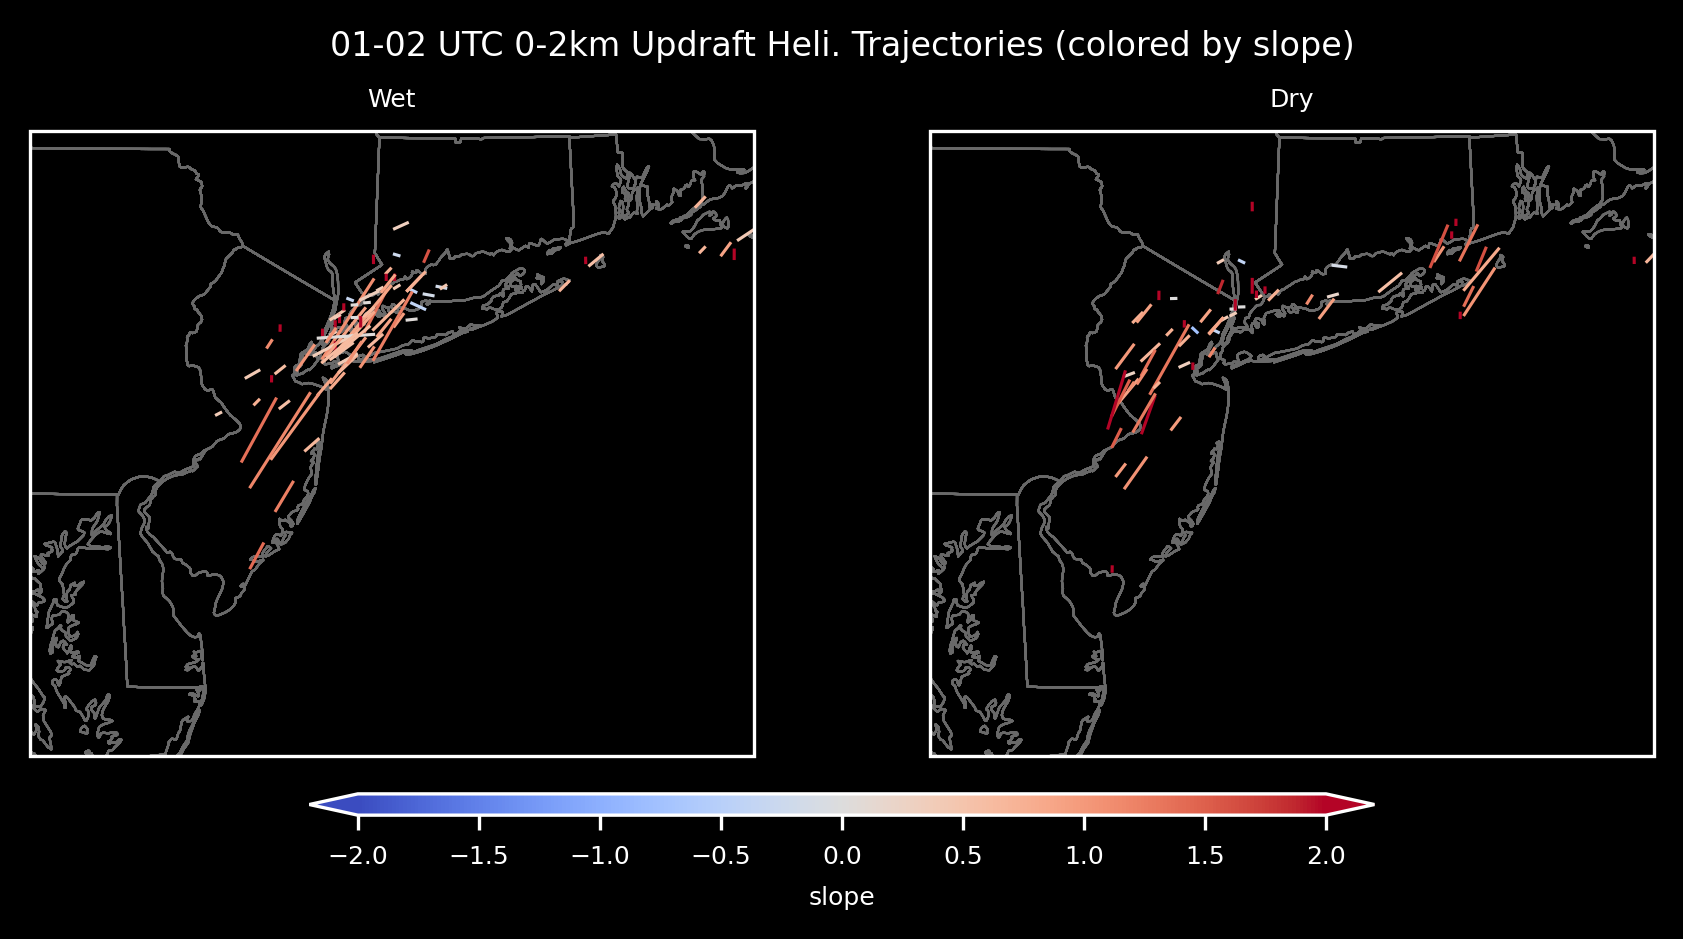

In [ ]:
# Define a colormap for the slopes (using 'coolwarm' as an example)
cmap = plt.get_cmap("coolwarm")

# Normalize the slope values to be between -1 and 1 for the colormap
norm = mcolors.Normalize(vmin=-2, vmax=2)

data = [uh_wet.max(dim="time"), uh_dry.max(dim="time")]
titles = ["Wet", "Dry"]

fig, axes = plt.subplots(
    1,
    2,
    figsize=(6, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i, ax in enumerate(axes.flat):
    for j in range(len(data[i].run)):
        # Find where UH exceeds threshold
        mask = data[i].isel(run=j) > 20

        # Label continuous blobs in the mask
        labeled_array, num_features = label(mask)

        # Iterate over each blob
        for blob in range(1, num_features + 1):
            # Find the indices of the current blob
            blob_mask = labeled_array == blob
            uh_points = np.column_stack(
                np.where(blob_mask)
            )  # Get lat/lon indices of UH > 20 for this blob

            # Exclude any blobs that are only one grid box big
            if uh_points.shape[0] > 1:
                # Convert indices to lat/lon using the mask, accessing values from xarray
                lats = lat.values[
                    uh_points[:, 0], uh_points[:, 1]
                ].flatten()  # Get numpy array, then flatten
                lons = lon.values[
                    uh_points[:, 0], uh_points[:, 1]
                ].flatten()  # Same for lons

                # Skip the regression if all x (lon) values are identical
                if np.amax(lons) != np.amin(lons):
                    # Fit a line to the lons and lats (simplified storm trajectory)
                    slope, intercept, _, _, _ = stats.linregress(lons, lats)

                    # Create line based on the slope and intercept
                    line_lons = np.array([lons.min(), lons.max()])
                    line_lats = slope * line_lons + intercept

                    # Get color from the colormap based on the slope
                    color = cmap(norm(slope))

                    # Plot the fitted line as an estimate of storm trajectory
                    ax.plot(
                        line_lons,
                        line_lats,
                        transform=ccrs.PlateCarree(),
                        color=color,
                        linewidth=0.75,
                    )

        # Add state borders for each subplot
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray")

    # Set title and map extent
    ax.set_title(titles[i], fontsize=6)
    ax.set_extent([-76.5, -70.5, 38, 42])

# Add a colorbar to show the slope values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(
    sm, ax=axes, orientation="horizontal", shrink=0.6, aspect=50, extend="both"
)
cb.ax.tick_params(labelsize=6)
cb.set_label("slope", fontsize=6)


plt.suptitle(
    "01-02 UTC 0-2km Updraft Heli. > 20m$^2$s$^{-2}$ Trajectories (colored by slope)", fontsize=8
)
plt.show()


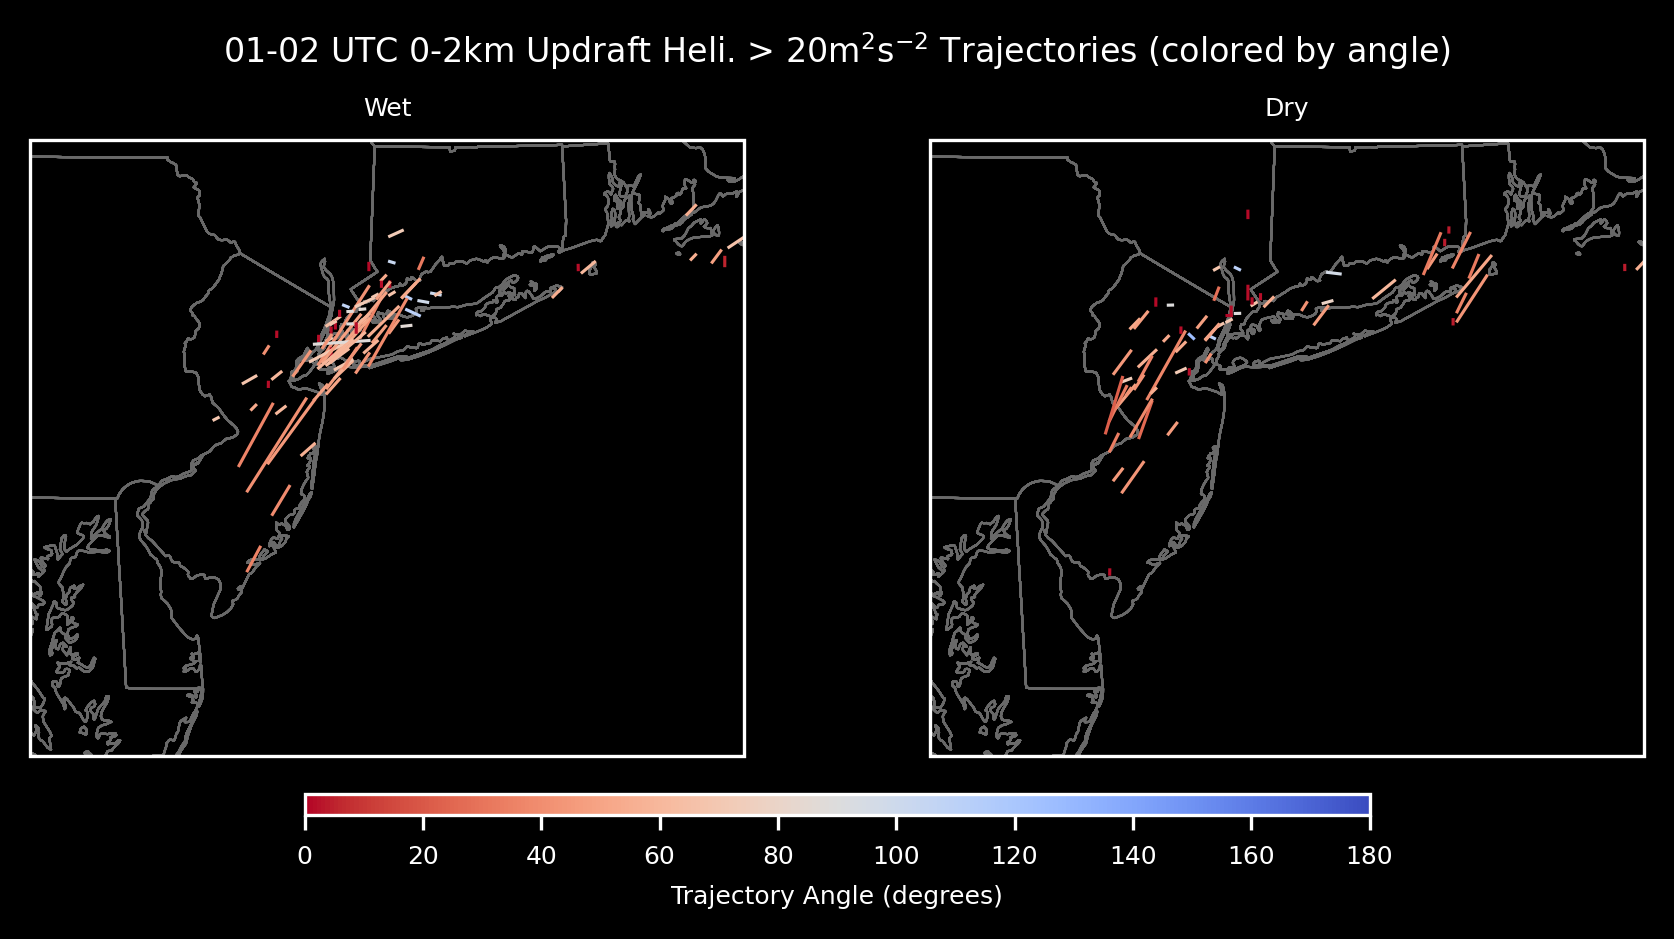

In [52]:
# Define a colormap for the angles (using 'coolwarm' as an example)
cmap = plt.get_cmap("coolwarm_r")

# Normalize the angle values to be between 0 and 180 for the colormap
norm = mcolors.Normalize(vmin=0, vmax=180)

data = [uh_wet.max(dim="time"), uh_dry.max(dim="time")]
titles = ["Wet", "Dry"]

fig, axes = plt.subplots(
    1,
    2,
    figsize=(6, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i, ax in enumerate(axes.flat):
    for j in range(len(data[i].run)):
        # Find where UH exceeds threshold
        mask = data[i].isel(run=j) > 20

        # Label continuous blobs in the mask
        labeled_array, num_features = label(mask)

        # Iterate over each blob
        for blob in range(1, num_features + 1):
            # Find the indices of the current blob
            blob_mask = labeled_array == blob
            uh_points = np.column_stack(
                np.where(blob_mask)
            )  # Get lat/lon indices of UH > 20 for this blob

            # Exclude any blobs that are only one grid box big
            if uh_points.shape[0] > 1:
                # Convert indices to lat/lon using the mask, accessing values from xarray
                lats = lat.values[uh_points[:, 0], uh_points[:, 1]]
                lons = lon.values[uh_points[:, 0], uh_points[:, 1]]

                # Skip the regression if all x (lon) values are identical
                if np.amax(lons) != np.amin(lons):
                    # Fit a line to the lons and lats (simplified storm trajectory)
                    slope, intercept, _, _, _ = stats.linregress(lons, lats)

                    # Create line based on the slope and intercept (straight line)
                    line_lons = np.array([lons.min(), lons.max()])
                    line_lats = slope * line_lons + intercept

                    # Calculate the angle from the slope using arctan
                    angle_deg = np.degrees(np.arctan(slope))

                    # Adjust angles for negative slopes to fit the range [90, 180]
                    if angle_deg < 0:
                        angle_deg = 180 - (
                            90 + angle_deg
                        )  # Ensure angle is within the [90, 180] range
                    # Adjust positive angles so that 0 is north
                    elif angle_deg > 0:
                        angle_deg = 90 - angle_deg

                    # Get color from the colormap based on the angle
                    color = cmap(norm(angle_deg))

                    # Plot the fitted line as an estimate of storm trajectory
                    ax.plot(
                        line_lons,
                        line_lats,
                        transform=ccrs.PlateCarree(),
                        color=color,
                        linewidth=0.75,
                    )

        # Add state borders for each subplot
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray")

    # Set title and map extent
    ax.set_title(titles[i], fontsize=6)
    ax.set_extent([-76.5, -70.5, 38, 42])

# Add a colorbar to show the angle values (90 to 180 degrees)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=axes, orientation="horizontal", shrink=0.6, aspect=50)
cb.ax.tick_params(labelsize=6)
cb.set_label("Trajectory Angle (degrees)", fontsize=6)

plt.suptitle(
    "01-02 UTC 0-2km Updraft Heli. > 20m$^2$s$^{-2}$ Trajectories (colored by angle)",
    fontsize=8,
)
plt.show()


In [51]:
# Initialize lists to hold angles for wet and dry ensembles
wet_angles = []
dry_angles = []

data = [uh_wet.max(dim="time"), uh_dry.max(dim="time")]

for i in range(2):  # Loop over wet and dry ensembles
    for j in range(len(data[i].run)):
        # Find where UH exceeds threshold
        mask = data[i].isel(run=j) > 20

        # Label continuous blobs in the mask
        labeled_array, num_features = label(mask)

        # Iterate over each blob
        for blob in range(1, num_features + 1):
            # Find the indices of the current blob
            blob_mask = labeled_array == blob
            uh_points = np.column_stack(
                np.where(blob_mask)
            )  # Get lat/lon indices of UH > 20 for this blob

            # Exclude any blobs that are only one grid box big
            if uh_points.shape[0] > 1:
                # Convert indices to lat/lon using the mask, accessing values from xarray
                lats = lat.values[
                    uh_points[:, 0], uh_points[:, 1]
                ].flatten()  # Get numpy array, then flatten
                lons = lon.values[
                    uh_points[:, 0], uh_points[:, 1]
                ].flatten()  # Same for lons

                # Skip the regression if all x (lon) values are identical
                if np.amax(lons) != np.amin(lons):
                    # Fit a line to the lons and lats (simplified storm trajectory)
                    slope, intercept, _, _, _ = stats.linregress(lons, lats)

                    # Calculate the angle from the slope using arctan
                    angle_deg = np.degrees(np.arctan(slope))

                    # Adjust angles for negative slopes to fit the range [90, 180]
                    if angle_deg < 0:
                        angle_deg = 180 - (
                            90 + angle_deg
                        )  # Ensure angle is within the [90, 180] range
                    # Adjust positive angles so that 0 is north
                    elif angle_deg > 0:
                        angle_deg = 90 - angle_deg

                    # Store the angle in the corresponding list
                    if i == 0:
                        wet_angles.append(angle_deg)
                    else:
                        dry_angles.append(angle_deg)

# Calculate ensemble mean angles for wet and dry ensembles
mean_wet_angle = np.mean(wet_angles) if wet_angles else np.nan  # Handle empty case
mean_dry_angle = np.mean(dry_angles) if dry_angles else np.nan  # Handle empty case

print(f"Ensemble mean angle (wet): {mean_wet_angle}")
print(f"Ensemble mean angle (dry): {mean_dry_angle}")

# Perform a two-sample t-test to check if the mean angles are significantly different
if wet_angles and dry_angles:  # Ensure both lists are not empty
    t_stat, p_value = stats.ttest_ind(
        wet_angles, dry_angles, equal_var=False
    )  # Welch's t-test (unequal variances)

    print(f"t-statistic: {t_stat}, p-value: {p_value}")

    # Interpret p-value
    alpha = 0.05  # 5% significance level
    if p_value < alpha:
        print("The difference in mean trajectory angles is statistically significant.")
    else:
        print(
            "The difference in mean trajectory angles is NOT statistically significant."
        )
else:
    print("Insufficient data for statistical testing.")


Ensemble mean angle (wet): 51.40906989975313
Ensemble mean angle (dry): 42.98984714300404
t-statistic: 1.7472533894515887, p-value: 0.08290932684287962
The difference in mean trajectory angles is NOT statistically significant.


## Multiple times

In [6]:
# Extract updraft helicity
uh_wet = get_field(
    wofs_wet, "uh_0to2", "2021-09-01 23:05:00", "2021-09-02 02:00:00", init
).stack(run=("init", "ne"))
uh_dry = get_field(
    wofs_dry, "uh_0to2", "2021-09-01 23:05:00", "2021-09-02 02:00:00", init
).stack(run=("init", "ne"))


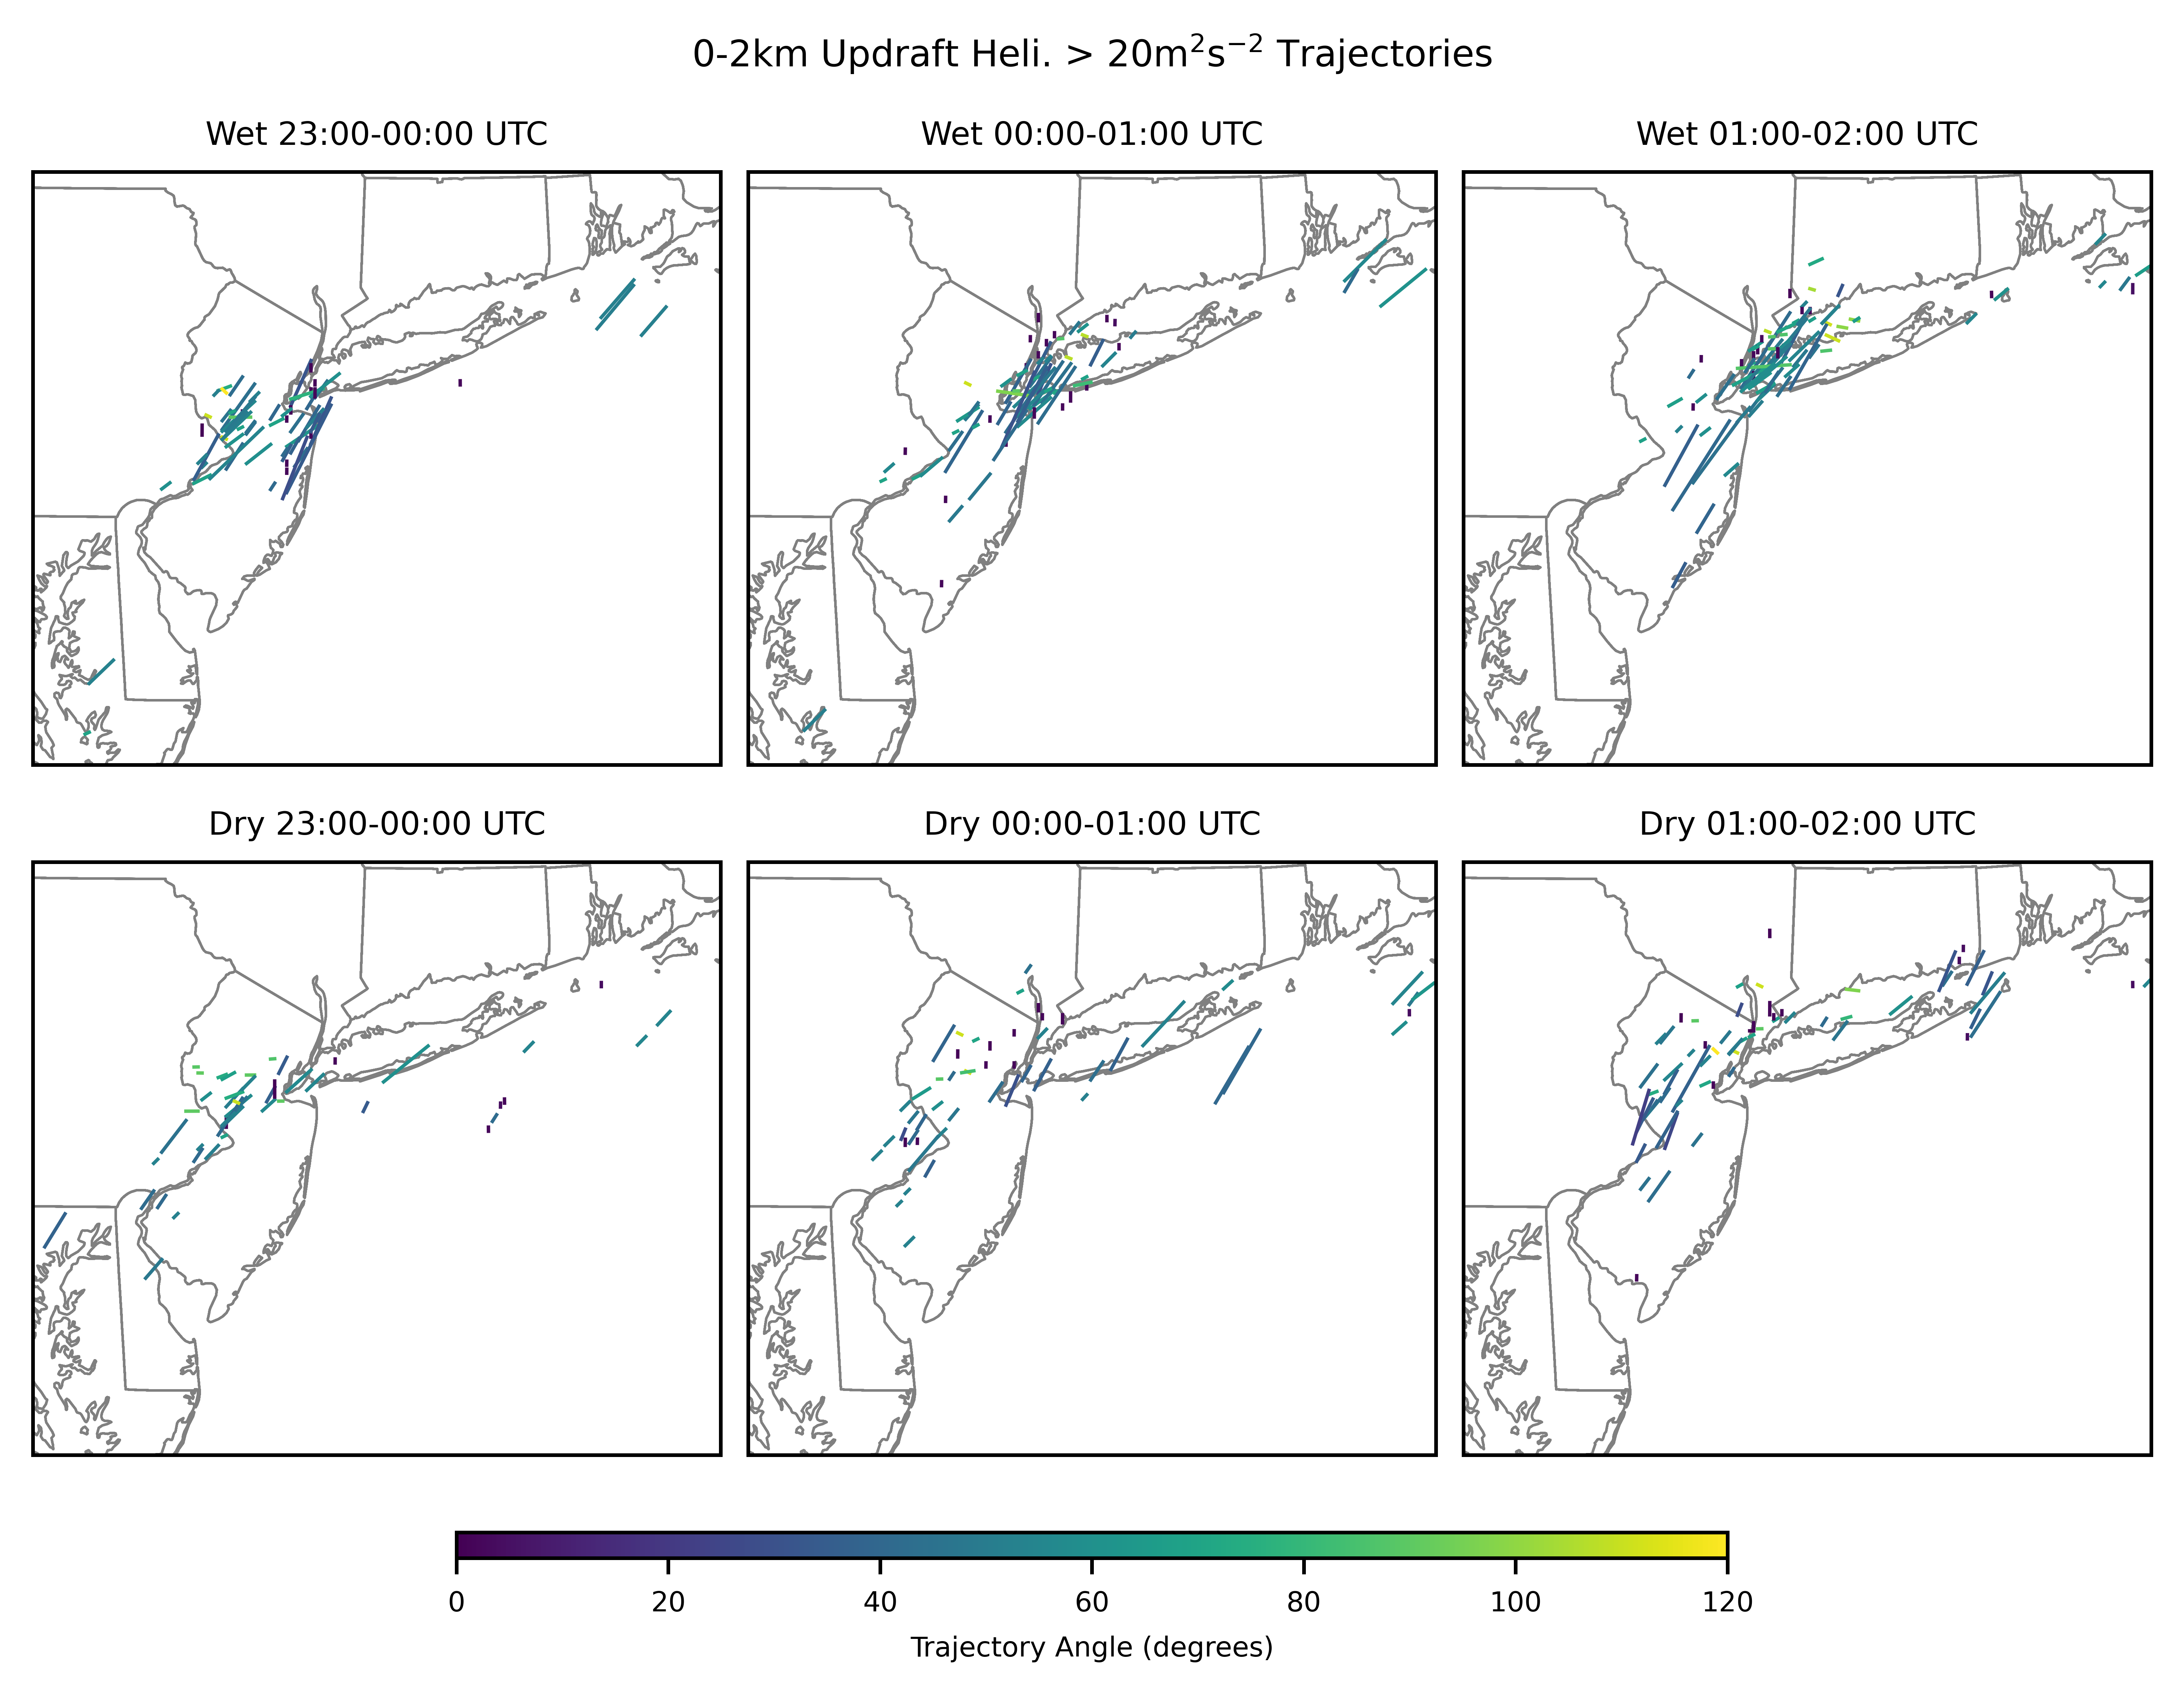

In [8]:
plt.style.use("default")

# Define a colormap for the angles (using 'coolwarm' as an example)
cmap = plt.get_cmap("viridis")

# Normalize the angle values to be between 0 and 180 for the colormap
norm = mcolors.Normalize(vmin=0, vmax=120)

starts = ["2021-09-01 23:05", "2021-09-02 00:05", "2021-09-02 01:05"]
ends = ["2021-09-02 00:00", "2021-09-02 01:00", "2021-09-02 02:00"]

data = []
for s, e in zip(starts, ends):
    data.append(uh_wet.sel(time=slice(s, e)).max(dim="time"))
for s, e in zip(starts, ends):
    data.append(uh_dry.sel(time=slice(s, e)).max(dim="time"))
titles = [
    "Wet 23:00-00:00 UTC",
    "Wet 00:00-01:00 UTC",
    "Wet 01:00-02:00 UTC",
    "Dry 23:00-00:00 UTC",
    "Dry 00:00-01:00 UTC",
    "Dry 01:00-02:00 UTC",
]

fig, axes = plt.subplots(
    2,
    3,
    figsize=(6.5, 5),
    dpi=900,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i, ax in enumerate(axes.flat):
    for j in range(len(data[i].run)):
        # Find where UH exceeds threshold
        mask = data[i].isel(run=j) > 20

        # Label continuous blobs in the mask
        labeled_array, num_features = label(mask)

        # Iterate over each blob
        for blob in range(1, num_features + 1):
            # Find the indices of the current blob
            blob_mask = labeled_array == blob
            uh_points = np.column_stack(
                np.where(blob_mask)
            )  # Get lat/lon indices of UH > 20 for this blob

            # Exclude any blobs that are only one grid box big
            if uh_points.shape[0] > 1:
                # Convert indices to lat/lon using the mask, accessing values from xarray
                lats = lat.values[uh_points[:, 0], uh_points[:, 1]]
                lons = lon.values[uh_points[:, 0], uh_points[:, 1]]

                # Skip the regression if all x (lon) values are identical
                if np.amax(lons) != np.amin(lons):
                    # Fit a line to the lons and lats (simplified storm trajectory)
                    slope, intercept, _, _, _ = stats.linregress(lons, lats)

                    # Create line based on the slope and intercept (straight line)
                    line_lons = np.array([lons.min(), lons.max()])
                    line_lats = slope * line_lons + intercept

                    # Calculate the angle from the slope using arctan
                    angle_deg = np.degrees(np.arctan(slope))

                    # Adjust angles for negative slopes to fit the range [90, 180]
                    if angle_deg < 0:
                        angle_deg = 180 - (
                            90 + angle_deg
                        )  # Ensure angle is within the [90, 180] range
                    # Adjust positive angles so that 0 is north
                    elif angle_deg > 0:
                        angle_deg = 90 - angle_deg

                    # Get color from the colormap based on the angle
                    color = cmap(norm(angle_deg))

                    # Plot the fitted line as an estimate of storm trajectory
                    ax.plot(
                        line_lons,
                        line_lats,
                        transform=ccrs.PlateCarree(),
                        color=color,
                        linewidth=0.75,
                    )

        # Add state borders for each subplot
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="gray")

    # Set title and map extent
    ax.set_title(titles[i], fontsize=7)
    ax.set_extent([-76.5, -70.5, 38, 42])

# Add a colorbar to show the angle values (90 to 180 degrees)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=axes, orientation="horizontal", shrink=0.6, aspect=50)
cb.ax.tick_params(labelsize=6)
cb.set_label("Trajectory Angle (degrees)", fontsize=6)

plt.suptitle(
    "0-2km Updraft Heli. > 20m$^2$s$^{-2}$ Trajectories",
    fontsize=8,
)
plt.show()
